# **PRODIGY_DS_02 BY HARSH THAKKAR**
# **Task-2: Performing EDA and Data Cleaning on Titanic Dataset.**

# (1) Importing necessary libraries.

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from matplotlib import pyplot as plt
import sklearn
from sklearn.tree import DecisionTreeClassifier #Decision Tree Classifier
from sklearn.preprocessing import StandardScaler #Scales To Unit Variance
from sklearn.model_selection import train_test_split #Train-Test Split
from sklearn.metrics import accuracy_score,classification_report, precision_recall_curve, confusion_matrix #Statistical Approaches
import warnings
warnings.filterwarnings("ignore")

# (2) Importing a Dataset.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Read data
train = pd.read_csv('/content/drive/MyDrive/Prodigy Infotech Data Science Internship/Task-2/train.csv')
test = pd.read_csv('/content/drive/MyDrive/Prodigy Infotech Data Science Internship/Task-2/test.csv')

# (3) Data Exploration (EDA)

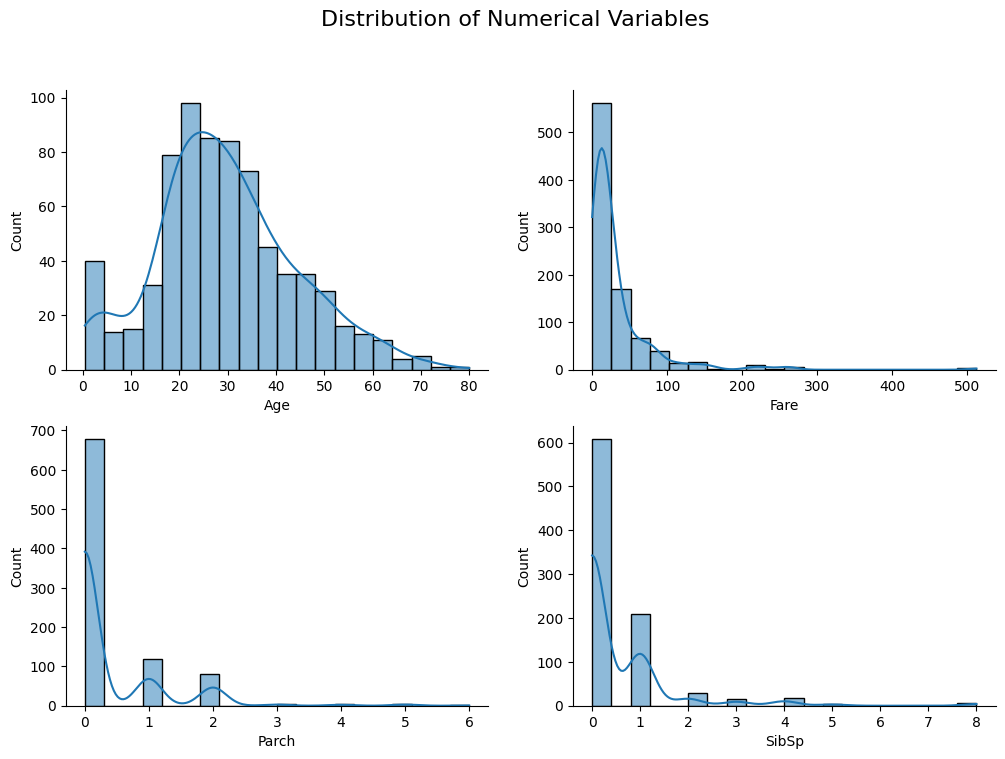

In [ ]:
# Distribution of numerical independent variables
numerical_columns = ['Age', 'Fare', 'Parch', 'SibSp']
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
fig.suptitle("Distribution of Numerical Variables", fontsize=16)
for i,column in enumerate(numerical_columns):
    sns.histplot(train[column], bins = 20, kde = True, ax = axes[i//2,i%2])
    sns.despine()

plt.show()

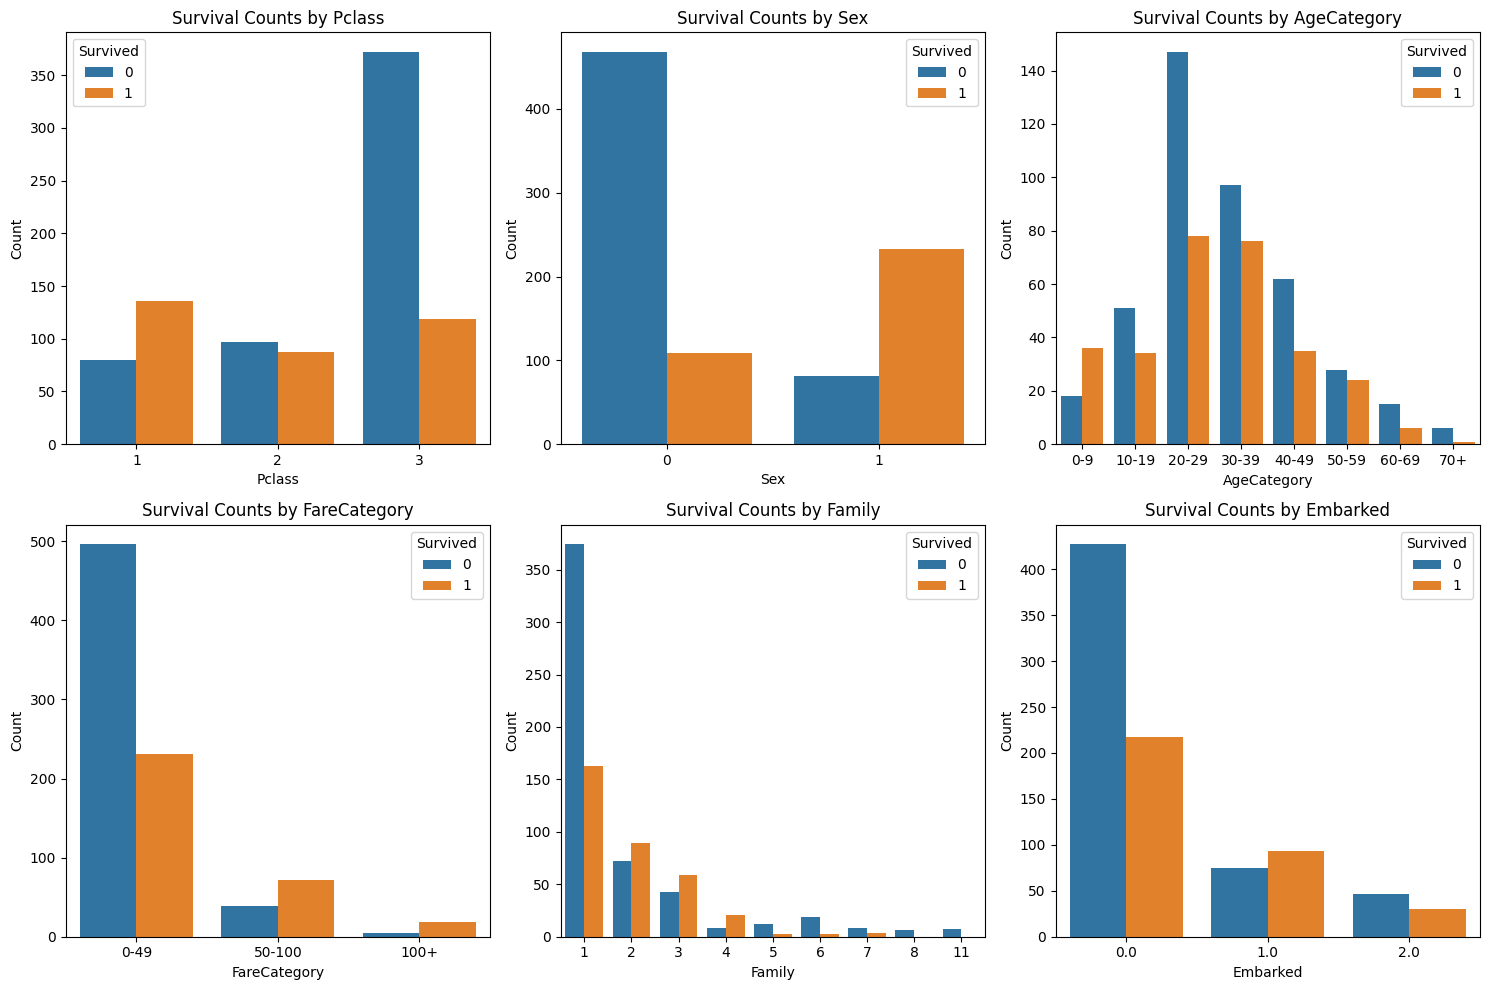

In [ ]:
# Feature Engineering With Relevant Themes
# Sex
train['Sex'] = train['Sex'].map({'male': 0, 'female': 1})
train['Embarked'] = train ['Embarked'].map({'S':0,'C':1,'Q':2})

# Family
train['Family'] = train['SibSp'] + train['Parch'] + 1

# Make Age Categorical
age_bins = [0,9,19,29,39,49,59,69,89]
age_labels = ['0-9','10-19','20-29','30-39','40-49','50-59','60-69','70+']
train['AgeCategory'] = pd.cut(train['Age'], bins = age_bins, labels = age_labels, right = False)

# Make Fare Categorical
fare_bins = [0,49,99,150]
fare_labels = ['0-49','50-100','100+']
train['FareCategory'] = pd.cut(train['Fare'], bins = fare_bins, labels = fare_labels, right = False)

# Relevant variables
categorical_vars = ['Pclass', 'Sex', 'AgeCategory', 'FareCategory', 'Family', 'Embarked',]

# Create a subplot with multiple categorical variables
fig, axes = plt.subplots(nrows = 2, ncols = 3, figsize=(15, 10))
axes = axes.flatten()

# Iterate over each categorical variable and create a countplot
for i, var in enumerate(categorical_vars):
    sns.countplot(x=var, hue='Survived', data=train, ax=axes[i])
    axes[i].set_title(f'Survival Counts by {var}')
    axes[i].set_xlabel(var)
    axes[i].set_ylabel('Count')

plt.tight_layout()
plt.show()

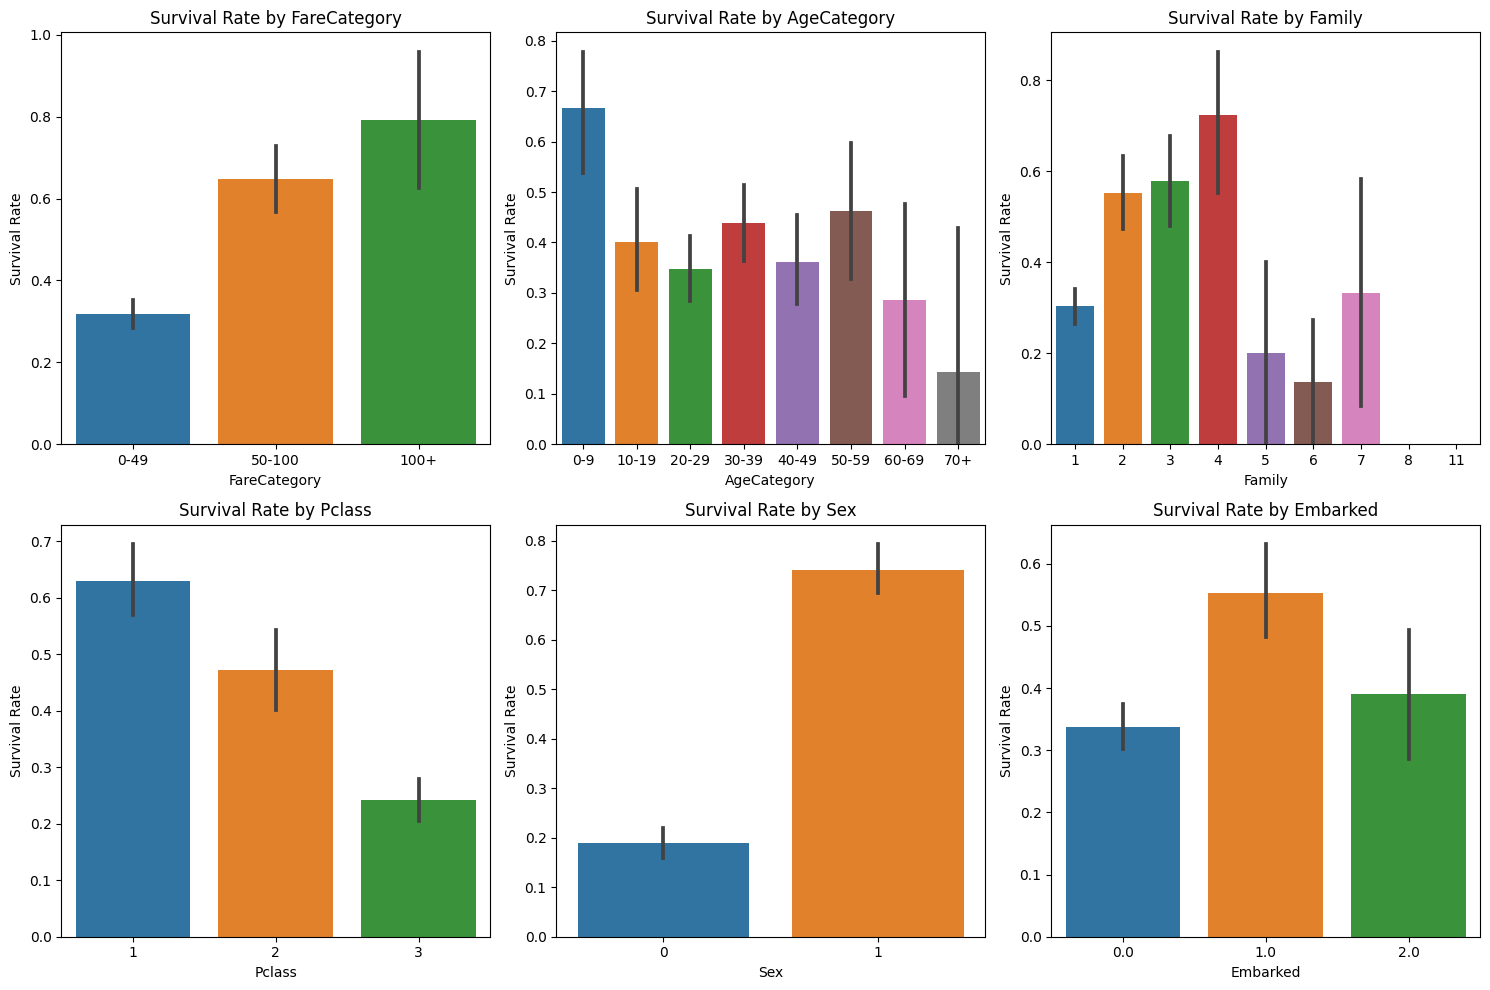

In [ ]:
# Show Survival Rates for different features
columns_to_plot = ['FareCategory', 'AgeCategory', 'Family', 'Pclass', 'Sex', 'Embarked']
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
axes = axes.flatten()

for i, column in enumerate(columns_to_plot):
    sns.barplot(x=column, y='Survived', data=train, ax=axes[i])
    axes[i].set_title(f'Survival Rate by {column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Survival Rate')

plt.tight_layout()
plt.show()

# (4) Data Cleaning

In [ ]:
# Deal with Outliers
numerical_columns = ['Age', 'SibSp', 'Parch', 'Fare']

def remove_outliers_iqr(data, columns):
    replaced_outliers_count = {}  # Initialize the dictionary to store the count of replaced outliers

    for column in columns:
        Q1 = data[column].quantile(0.25)
        Q3 = data[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        # Count the outliers before replacement
        outliers_before = sum((data[column] < lower_bound) | (data[column] > upper_bound))
        # Replace the outliers
        data[column] = data.apply(lambda row: lower_bound if row[column] < lower_bound else (upper_bound if row[column] > upper_bound else row[column]), axis=1)
        # Count the outliers after replacement
        outliers_after = sum((data[column] < lower_bound) | (data[column] > upper_bound))
        # Store the count of replaced outliers
        replaced_outliers_count[column] = outliers_before - outliers_after

    return data, replaced_outliers_count

replace_outliers_train, replaced_outliers_count_train = remove_outliers_iqr(train.copy(), numerical_columns)
replace_outliers_test, replaced_outliers_count_test = remove_outliers_iqr(test.copy(), numerical_columns)

# Print the counts of replaced outliers
print("Replaced Outliers in Train Data:")
print(replaced_outliers_count_train)

print("\nReplaced Outliers in Test Data:")
print(replaced_outliers_count_test)

# Ensure no data was accidentally deleted
print("\nOriginal Train Shape:", train.shape)
print("Train Shape After Outlier Replacement:", replace_outliers_train.shape)

print("Original Test Shape:", test.shape)
print("Test Shape After Outlier Replacement:", replace_outliers_test.shape)

Replaced Outliers in Train Data:
{'Age': 11, 'SibSp': 46, 'Parch': 213, 'Fare': 116}

Replaced Outliers in Test Data:
{'Age': 2, 'SibSp': 11, 'Parch': 94, 'Fare': 55}

Original Train Shape: (891, 15)
Train Shape After Outlier Replacement: (891, 15)
Original Test Shape: (418, 11)
Test Shape After Outlier Replacement: (418, 11)


In [ ]:
# Replacing null values for both sets
# Train set
train_age_median = train['Age'].median()
train['Age'] = train['Age'].replace(np.nan, train_age_median)

train_fare_median = train['Fare'].median()
train['Fare'] = train['Fare'].replace(np.nan, train_fare_median)

# Test set
test_age_median = test['Age'].median()
test['Age'] = test['Age'].replace(np.nan, test_age_median)

test_fare_median = test['Fare'].median()
test['Fare'] = test['Fare'].replace(np.nan, test_fare_median)

test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          327
Embarked         0
dtype: int64

In [ ]:
# Match Feature Engineering from training Data
# Sex
test['Sex'] = test['Sex'].map({'male': 0, 'female': 1})

# Family
test['Family'] = test['SibSp'] + test['Parch'] + 1

# Make Age Categorical
age_bins = [0,9,19,29,39,49,59,69,89]
age_labels = ['0-9','10-19','20-29','30-39','40-49','50-59','60-69','70+']
test['AgeCategory'] = pd.cut(test['Age'], bins = age_bins, labels = age_labels, right = False)

# Make Fare Categorical
fare_bins = [0,49,99,150]
fare_labels = ['0-49','50-100','100+']
test['FareCategory'] = pd.cut(test['Fare'], bins = fare_bins, labels = fare_labels, right = False)

test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Family,AgeCategory,FareCategory
0,892,3,"Kelly, Mr. James",0,34.5,0,0,330911,7.8292,NaN,Q,1,30-39,0-49
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",1,47.0,1,0,363272,7.0000,NaN,S,2,40-49,0-49
2,894,2,"Myles, Mr. Thomas Francis",0,62.0,0,0,240276,9.6875,NaN,Q,1,60-69,0-49
3,895,3,"Wirz, Mr. Albert",0,27.0,0,0,315154,8.6625,NaN,S,1,20-29,0-49
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",1,22.0,1,1,3101298,12.2875,NaN,S,3,20-29,0-49


In [ ]:
# Replace null values for both new Columns
# Train Set
train_agecategory_mode = train['AgeCategory'].mode().iloc[0]
train['AgeCategory'] = train['AgeCategory'].fillna(train_agecategory_mode)

train_farecategory_mode = train['FareCategory'].mode().iloc[0]
train['FareCategory'] = train['FareCategory'].fillna(train_farecategory_mode)

# Test Set
test_agecategory_mode = test['AgeCategory'].mode().iloc[0]
test['AgeCategory'] = test['AgeCategory'].fillna(test_agecategory_mode)

test_farecategory_mode = test['FareCategory'].mode().iloc[0]
test['FareCategory'] = test['FareCategory'].fillna(test_farecategory_mode)

# Display nulls
train.isnull().sum()

PassengerId       0
Survived          0
Pclass            0
Name              0
Sex               0
Age               0
SibSp             0
Parch             0
Ticket            0
Fare              0
Cabin           687
Embarked          2
Family            0
AgeCategory       0
FareCategory      0
dtype: int64

In [ ]:
# Drop Unnecessary Columns from both sets of data
# Train Set
train_columns_to_drop = ['PassengerId','Name','Age','Fare','SibSp','Parch','Ticket','Cabin','Embarked']
train = train.drop(columns = train_columns_to_drop)
# Test Set
test_columns_to_drop = ['Name','Age','Fare','SibSp','Parch','Ticket','Cabin','Embarked']
test = test.drop(columns = test_columns_to_drop)

In [ ]:
# Convert data types for both sets of data
# Train Set
train['AgeCategory'] = train['AgeCategory'].cat.codes.astype('Int64')
train['FareCategory'] = train['FareCategory'].cat.codes.astype('Int64')
#Test Set
test['AgeCategory'] = test['AgeCategory'].cat.codes.astype('Int64')
test['FareCategory'] = test['FareCategory'].cat.codes.astype('Int64')

print(train.dtypes)
print(test.dtypes)

Survived        int64
Pclass          int64
Sex             int64
Family          int64
AgeCategory     Int64
FareCategory    Int64
dtype: object
PassengerId     int64
Pclass          int64
Sex             int64
Family          int64
AgeCategory     Int64
FareCategory    Int64
dtype: object


In [ ]:
# View Train Set
train.head()

,Survived,Pclass,Sex,Family,AgeCategory,FareCategory
0,0,3,0,2,2,0
1,1,1,1,2,3,1
2,1,3,1,1,2,0
3,1,1,1,2,3,1
4,0,3,0,1,3,0


In [ ]:
# View Test Set
test.head()

,PassengerId,Pclass,Sex,Family,AgeCategory,FareCategory
0,892,3,0,1,3,0
1,893,3,1,2,4,0
2,894,2,0,1,6,0
3,895,3,0,1,2,0
4,896,3,1,3,2,0


# (5) Correlation Diagram

<Axes: title={'center': 'Pearson Correlation of Features'}>

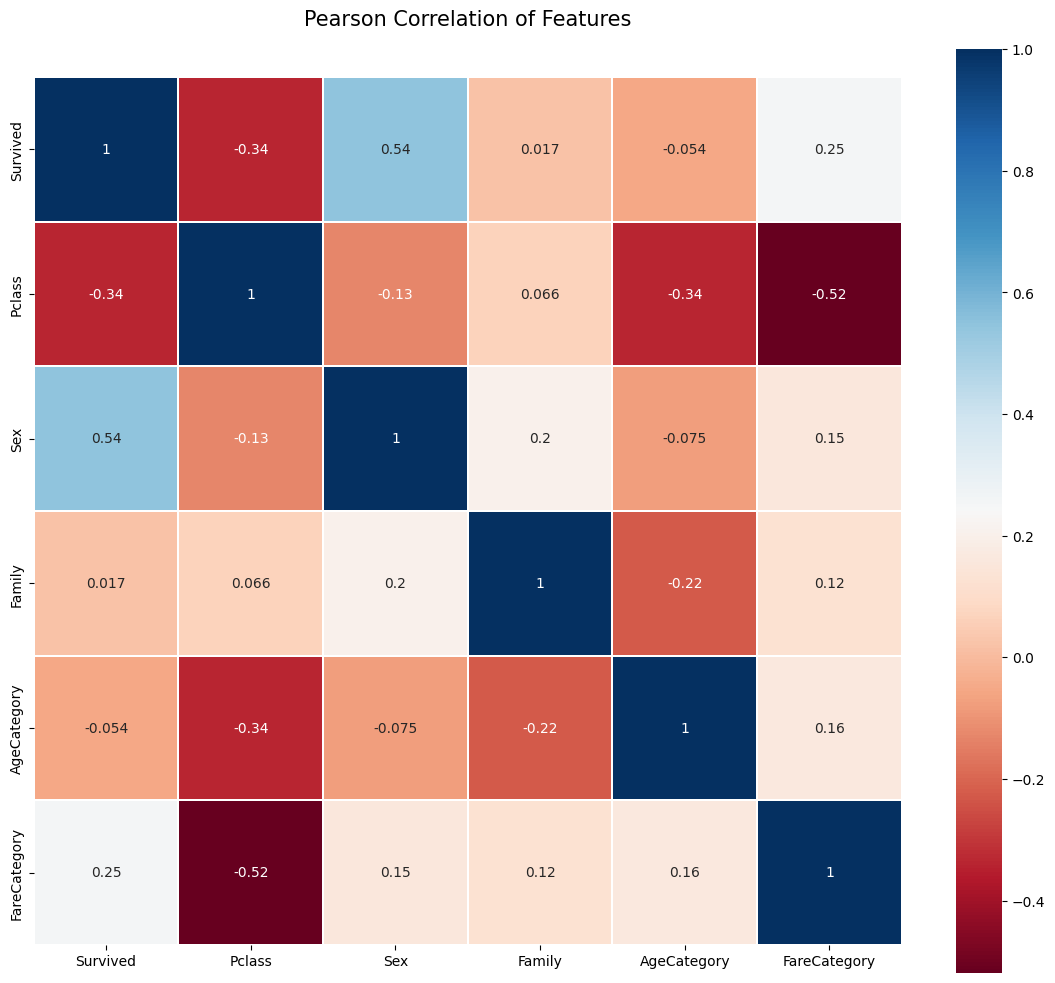

In [ ]:
# Pearson correlation to see relationships between variables
colormap = plt.cm.RdBu
plt.figure(figsize = (14,12))
plt.title('Pearson Correlation of Features', y = 1.05, size = 15)
sns.heatmap(train.astype(float).corr(),linewidths = .1, vmax = 1.0, square = True, cmap = colormap, linecolor = 'white', annot = True)

# (6) Model Applied

In [ ]:
# Split train and test sets
X = train.drop('Survived', axis=1)  # Features
Y = train['Survived']  # Target variable

# Split the data into training and testing sets
# Test size of .469 used since 418/891 = .469
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.469, random_state=42)

In [ ]:
# Decision Trees
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, Y_train)
decision_tree_pred = decision_tree.predict(X_test)
acc_decision_tree = round(decision_tree.score(X_test, Y_test) * 100, 2)
print("The model accuracy for Decision Tree is ",acc_decision_tree)
print(len(decision_tree_pred))

The model accuracy for Decision Tree is  81.82
418
